# 3. Modelo de Gradient Boosting Regressor - Pronóstico de Demanda Eléctrica

Este notebook implementa un modelo de **Gradient Boosting Regressor** para predecir el consumo eléctrico horario de la región PJM East.

## Objetivo:
Construir un modelo avanzado de ensemble learning que mejore las predicciones del modelo baseline (Regresión Lineal).

## Contenido:
1. **Carga y Preparación de Datos**
2. **Ingeniería de Características (Feature Engineering)**
3. **División de Datos** - Train/Test cronológico
4. **Entrenamiento del Modelo**
5. **Evaluación del Modelo** - MAE, RMSE, R²
6. **Importancia de Variables (Feature Importance)**
7. **Comparación con Regresión Lineal**
8. **Conclusiones y Próximos Pasos**

---
## 1. Carga y Preparación de Datos

In [39]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import GradientBoostingRegressor
print("Usaremos sklearn.GradientBoostingRegressor")

# Configuración de estilo para gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12
sns.set_palette('husl')

print("\nLibrerías importadas correctamente")

Usaremos sklearn.GradientBoostingRegressor

Librerías importadas correctamente


In [25]:
# Cargar el dataset
df = pd.read_csv('PJME_hourly.csv', parse_dates=['Datetime'])

# Ordenar por fecha y establecer como índice
df = df.sort_values('Datetime').reset_index(drop=True)
df.set_index('Datetime', inplace=True)

print("DATASET CARGADO")
print("=" * 50)
print(f"\nInformación del Dataset:")
print(f"   - Registros: {len(df):,}")
print(f"   - Período: {df.index.min().strftime('%Y-%m-%d')} a {df.index.max().strftime('%Y-%m-%d')}")
print(f"   - Duración: {(df.index.max() - df.index.min()).days / 365:.1f} años")
print(f"\nEstadísticas del consumo (PJME_MW):")
print(f"   - Promedio: {df['PJME_MW'].mean():,.0f} MW")
print(f"   - Desv. Estándar: {df['PJME_MW'].std():,.0f} MW")
print(f"   - Mínimo: {df['PJME_MW'].min():,.0f} MW")
print(f"   - Máximo: {df['PJME_MW'].max():,.0f} MW")

DATASET CARGADO

Información del Dataset:
   - Registros: 145,366
   - Período: 2002-01-01 a 2018-08-03
   - Duración: 16.6 años

Estadísticas del consumo (PJME_MW):
   - Promedio: 32,080 MW
   - Desv. Estándar: 6,464 MW
   - Mínimo: 14,544 MW
   - Máximo: 62,009 MW


---
## 3. Ingeniería de Características (Feature Engineering)

Crearemos las mismas características que en el modelo de Regresión Lineal para una comparación justa.

In [26]:
def create_features(df):
    df = df.copy()
    
    # Características temporales
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    
    # Variables de retraso (lags)
    df['lag_1'] = df['PJME_MW'].shift(1)
    df['lag_24'] = df['PJME_MW'].shift(24)
    
    return df

# Aplicar la función
df = create_features(df)

print("Variables creadas:\n")
for col in ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'lag_1', 'lag_24']:
    print(f"   - {col}")

Variables creadas:

   - hour
   - dayofweek
   - quarter
   - month
   - year
   - dayofyear
   - lag_1
   - lag_24


In [27]:
# Manejar valores nulos
print("Manejo de valores nulos")

filas_antes = len(df)
df = df.dropna()
filas_eliminadas = filas_antes - len(df)

print(f"\n- Filas eliminadas: {filas_eliminadas}")
print(f"- Filas restantes: {len(df):,}")

Manejo de valores nulos

- Filas eliminadas: 24
- Filas restantes: 145,342


---
## 3. División de Datos: Entrenamiento y Test

Usamos la misma división cronológica que en Regresión Lineal para una comparación justa.

In [28]:
# Definir la fecha de corte
FECHA_CORTE = '2017-01-01'

# División cronológica
train = df.loc[df.index < FECHA_CORTE].copy()
test = df.loc[df.index >= FECHA_CORTE].copy()

print("Division de los Datos")
print(f"\nFecha de corte: {FECHA_CORTE}")
print(f"\nEntrenamiento: ")
print(f"   - Registros: {len(train):,}")
print(f"   - Período: {train.index.min().strftime('%Y-%m-%d')} a {train.index.max().strftime('%Y-%m-%d')}")
print(f"   - Porcentaje: {len(train)/len(df)*100:.1f}%")
print(f"\nTest:")
print(f"   - Registros: {len(test):,}")
print(f"   - Período: {test.index.min().strftime('%Y-%m-%d')} a {test.index.max().strftime('%Y-%m-%d')}")
print(f"   - Porcentaje: {len(test)/len(df)*100:.1f}%")

Division de los Datos

Fecha de corte: 2017-01-01

Entrenamiento: 
   - Registros: 131,446
   - Período: 2002-01-02 a 2016-12-31
   - Porcentaje: 90.4%

Test:
   - Registros: 13,896
   - Período: 2017-01-01 a 2018-08-03
   - Porcentaje: 9.6%


In [29]:
# Definir características y objetivo
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'lag_1', 'lag_24']
TARGET = 'PJME_MW'

# Separar X e y
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

print("Definición de Variables")
print(f"\nVariable Objetivo (y): {TARGET}")
print(f"\nCaracterísticas (X): {len(FEATURES)} variables")
for i, feat in enumerate(FEATURES, 1):
    print(f"   {i}. {feat}")
print(f"\nDimensiones:")
print(f"   - X_train: {X_train.shape}")
print(f"   - X_test: {X_test.shape}")

Definición de Variables

Variable Objetivo (y): PJME_MW

Características (X): 8 variables
   1. hour
   2. dayofweek
   3. quarter
   4. month
   5. year
   6. dayofyear
   7. lag_1
   8. lag_24

Dimensiones:
   - X_train: (131446, 8)
   - X_test: (13896, 8)


---
## 4. Entrenamiento del Modelo Gradient Boosting

### Configuración del Modelo:
- **n_estimators = 1000**: Usamos 1000 árboles para mejor precisión
- **learning_rate = 0.01**: Tasa baja para aprendizaje gradual
- **early_stopping** (si XGBoost): Detiene si no mejora en N rondas

In [30]:
# Configurar el modelo según disponibilidad
print("Configuracion del Modelo")
modelo_gb = GradientBoostingRegressor(
    n_estimators=500,  # Menos árboles por velocidad
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    random_state=42
    )
print("\nHiperparámetros:\n")
print("   - n_estimators: 500")
print("   - learning_rate: 0.05")
print("   - max_depth: 5")
print("   - subsample: 0.8")

Configuracion del Modelo

Hiperparámetros:

   - n_estimators: 500
   - learning_rate: 0.05
   - max_depth: 5
   - subsample: 0.8


In [31]:
# Entrenar el modelo
import time

print("Entrenando el Modelo...")
print("\nEsto puede tomar algunos minutos...\n")

start_time = time.time()

if USE_XGBOOST:
    # Con early stopping para XGBoost
    modelo_gb.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
else:
    modelo_gb.fit(X_train, y_train)

training_time = time.time() - start_time

print(f"Modelo entrenado exitosamente")
print(f"\nTiempo de entrenamiento: {training_time:.2f} segundos ({training_time/60:.2f} minutos)")

Entrenando el Modelo...

Esto puede tomar algunos minutos...

Modelo entrenado exitosamente

Tiempo de entrenamiento: 143.72 segundos (2.40 minutos)


---
## 6. Evaluación del Modelo

In [32]:
# Realizar predicciones
y_pred_gb = modelo_gb.predict(X_test)

# Calcular métricas
mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)
mape_gb = np.mean(np.abs((y_test - y_pred_gb) / y_test)) * 100

print("Métricas de Evaluación - Gradient Boosting")
print(f"\nMAE (Mean Absolute Error): {mae_gb:,.2f} MW")
print(f"  En promedio, el modelo se equivoca por ±{mae_gb:,.0f} MW")
print(f"\nRMSE (Root Mean Squared Error): {rmse_gb:,.2f} MW")
print(f"  Penaliza más los errores grandes")
print(f"\nR² (Coeficiente de Determinación): {r2_gb:.4f}")
print(f"  El modelo explica el {r2_gb*100:.2f}% de la varianza")
print(f"\nMAPE (Mean Absolute Percentage Error): {mape_gb:.2f}%")
print(f"  Error porcentual promedio")
print(f"\nContexto:")
print(f" Consumo promedio en test: {y_test.mean():,.0f} MW")
print(f" Error relativo (MAE/Media): {(mae_gb/y_test.mean())*100:.2f}%")

Métricas de Evaluación - Gradient Boosting

MAE (Mean Absolute Error): 303.73 MW
  En promedio, el modelo se equivoca por ±304 MW

RMSE (Root Mean Squared Error): 410.19 MW
  Penaliza más los errores grandes

R² (Coeficiente de Determinación): 0.9955
  El modelo explica el 99.55% de la varianza

MAPE (Mean Absolute Percentage Error): 0.96%
  Error porcentual promedio

Contexto:
 Consumo promedio en test: 31,069 MW
 Error relativo (MAE/Media): 0.98%


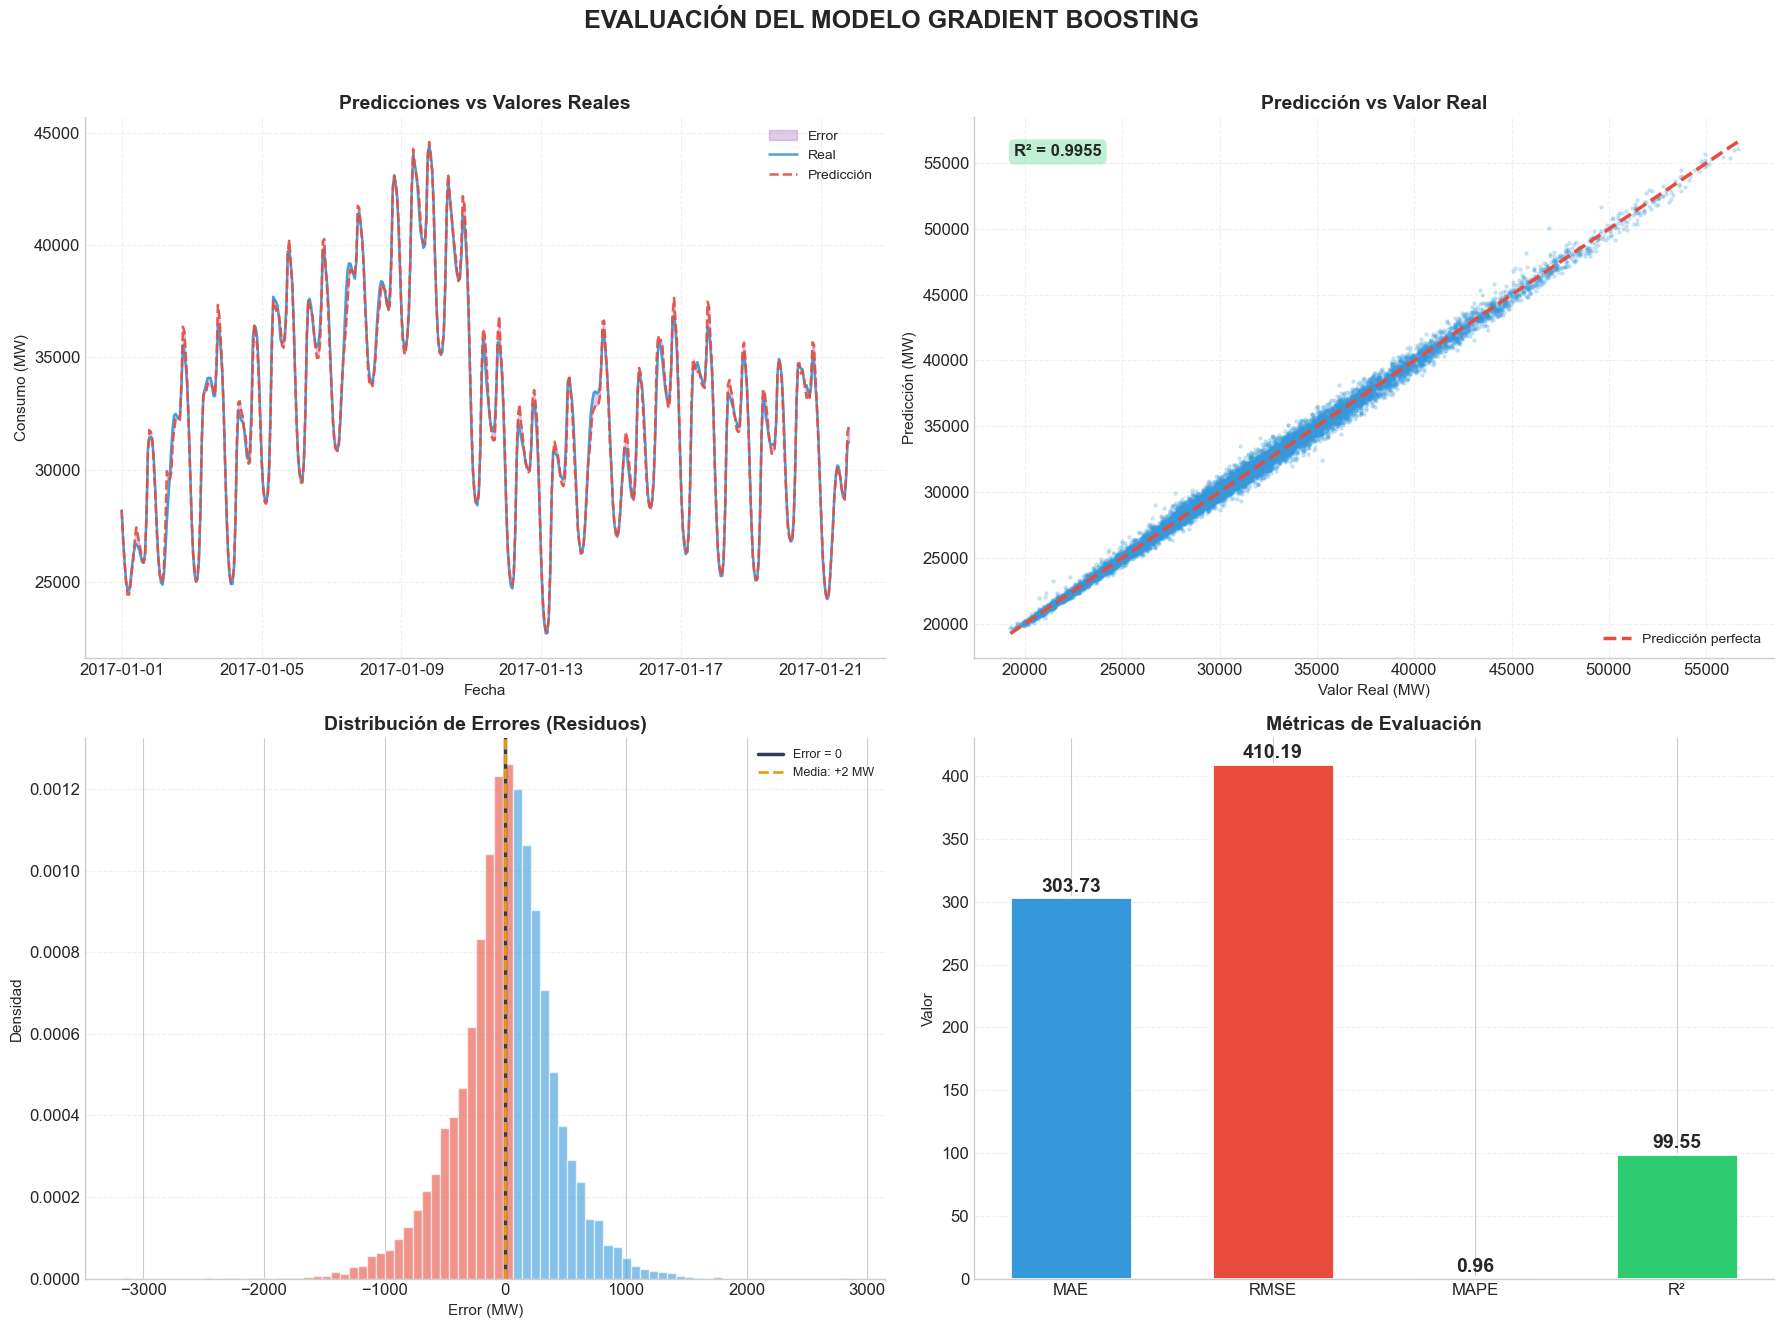

In [33]:
# Visualización de resultados
fig, axes = plt.subplots(2, 2, figsize=(18, 13))
fig.suptitle('EVALUACIÓN DEL MODELO GRADIENT BOOSTING', fontsize=18, fontweight='bold', y=1.02)

# Gráfico 1: Serie temporal
ax1 = axes[0, 0]
sample_size = 500

ax1.fill_between(test.index[:sample_size], 
                 y_test.values[:sample_size], 
                 y_pred_gb[:sample_size],
                 alpha=0.3, color='#9b59b6', label='Error')
ax1.plot(test.index[:sample_size], y_test.values[:sample_size], 
         color='#3498db', alpha=0.9, linewidth=1.8, label='Real')
ax1.plot(test.index[:sample_size], y_pred_gb[:sample_size], 
         color='#e74c3c', alpha=0.9, linewidth=1.8, linestyle='--', label='Predicción')

ax1.set_title('Predicciones vs Valores Reales', fontsize=14, fontweight='bold')
ax1.set_xlabel('Fecha', fontsize=11)
ax1.set_ylabel('Consumo (MW)', fontsize=11)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Gráfico 2: Scatter plot
ax2 = axes[0, 1]
ax2.scatter(y_test, y_pred_gb, alpha=0.2, color='#3498db', s=5)
lims = [min(y_test.min(), y_pred_gb.min()), max(y_test.max(), y_pred_gb.max())]
ax2.plot(lims, lims, color='#e74c3c', linestyle='--', linewidth=2.5, label='Predicción perfecta')

ax2.set_title('Predicción vs Valor Real', fontsize=14, fontweight='bold')
ax2.set_xlabel('Valor Real (MW)', fontsize=11)
ax2.set_ylabel('Predicción (MW)', fontsize=11)
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.text(0.05, 0.95, f'R² = {r2_gb:.4f}', transform=ax2.transAxes, fontsize=12, fontweight='bold', va='top',
         bbox=dict(boxstyle='round', facecolor='#2ecc71', edgecolor='none', alpha=0.3))

# Gráfico 3: Distribución de errores
ax3 = axes[1, 0]
errores_gb = y_test - y_pred_gb
n, bins, patches = ax3.hist(errores_gb, bins=80, color='#9b59b6', edgecolor='white', alpha=0.7, density=True)

for patch, left_edge in zip(patches, bins[:-1]):
    if left_edge < 0:
        patch.set_facecolor('#e74c3c')
        patch.set_alpha(0.6)
    else:
        patch.set_facecolor('#3498db')
        patch.set_alpha(0.6)

ax3.axvline(x=0, color='#2c3e50', linestyle='-', linewidth=2.5, label='Error = 0')
ax3.axvline(x=errores_gb.mean(), color='#f39c12', linestyle='--', linewidth=2, 
            label=f'Media: {errores_gb.mean():+.0f} MW')

ax3.set_title('Distribución de Errores (Residuos)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Error (MW)', fontsize=11)
ax3.set_ylabel('Densidad', fontsize=11)
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(True, alpha=0.3, linestyle='--', axis='y')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# Gráfico 4: Métricas
ax4 = axes[1, 1]
metricas_nombres = ['MAE', 'RMSE', 'MAPE', 'R²']
metricas_valores = [mae_gb, rmse_gb, mape_gb, r2_gb*100]
colores = ['#3498db', '#e74c3c', '#f39c12', '#2ecc71']

bars = ax4.bar(metricas_nombres, metricas_valores, color=colores, edgecolor='white', linewidth=2, width=0.6)

for bar, val in zip(bars, metricas_valores):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{val:,.2f}', ha='center', va='bottom', fontsize=14, fontweight='bold')

ax4.set_title('Métricas de Evaluación', fontsize=14, fontweight='bold')
ax4.set_ylabel('Valor', fontsize=11)
ax4.grid(True, alpha=0.3, axis='y', linestyle='--')
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

---
## 6. Importancia de Variables (Feature Importance)

Una de las ventajas de Gradient Boosting es que proporciona la **importancia de cada variable** basada en cuánto contribuye cada una a reducir el error.

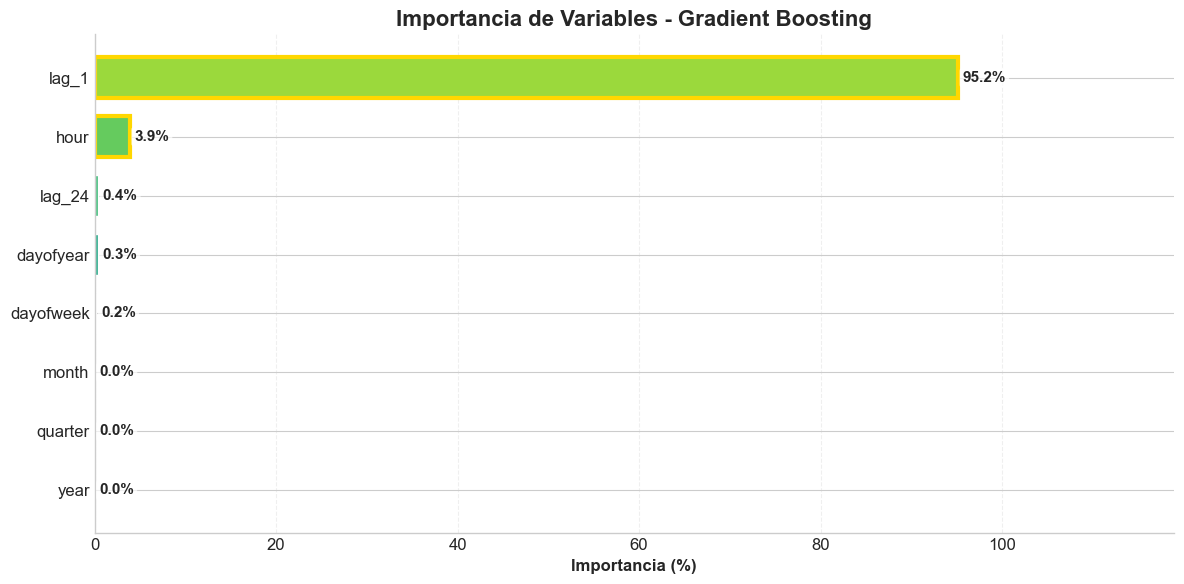


Interpretación:

Top 3 variables más importantes:
   lag_1: 95.2%
   hour: 3.9%
   lag_24: 0.4%

 Las variables LAG dominan porque el consumo tiene alta autocorrelación
 El modelo aprende que el consumo pasado es el mejor predictor del consumo futuro


In [34]:
# Obtener importancia de variables
importance_df = pd.DataFrame({
    'Feature': FEATURES,
    'Importance': modelo_gb.feature_importances_
}).sort_values('Importance', ascending=True)

# Normalizar a porcentaje
importance_df['Importance_Pct'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100

# Visualizar
fig, ax = plt.subplots(figsize=(12, 6))

# Coloreado
colors = plt.cm.viridis(np.linspace(0.25, 0.85, len(importance_df)))

bars = ax.barh(importance_df['Feature'], importance_df['Importance_Pct'], 
               color=colors, edgecolor='white', height=0.7)

# Destacar las 2 más importantes
top_2 = importance_df.nlargest(2, 'Importance')['Feature'].tolist()
for bar, feat in zip(bars, importance_df['Feature']):
    if feat in top_2:
        bar.set_edgecolor('#FFD700')
        bar.set_linewidth(3)

# Añadir valores
for bar, val in zip(bars, importance_df['Importance_Pct']):
    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{val:.1f}%', va='center', ha='left', fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none', alpha=0.7))

ax.set_xlabel('Importancia (%)', fontsize=12, fontweight='bold')
ax.set_title('Importancia de Variables - Gradient Boosting', fontsize=16, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.3, axis='x', linestyle='--')
ax.set_xlim(0, importance_df['Importance_Pct'].max() * 1.25)

plt.tight_layout()
plt.show()

print("\nInterpretación:")
print("\nTop 3 variables más importantes:")
for i, row in importance_df.nlargest(3, 'Importance').iterrows():
    print(f"   {row['Feature']}: {row['Importance_Pct']:.1f}%")
print("\n Las variables LAG dominan porque el consumo tiene alta autocorrelación")
print(" El modelo aprende que el consumo pasado es el mejor predictor del consumo futuro")

---
## 7. Comparación con Regresión Lineal

Comparemos el rendimiento de Gradient Boosting con el modelo baseline de Regresión Lineal.

In [35]:
# Entrenar modelo de Regresión Lineal para comparación
from sklearn.linear_model import LinearRegression

modelo_lr = LinearRegression()
modelo_lr.fit(X_train, y_train)
y_pred_lr = modelo_lr.predict(X_test)

# Métricas de Regresión Lineal
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
mape_lr = np.mean(np.abs((y_test - y_pred_lr) / y_test)) * 100

In [36]:
# Crear tabla comparativa
comparacion = pd.DataFrame({
    'Métrica': ['MAE (MW)', 'RMSE (MW)', 'R²', 'MAPE (%)'],
    'Regresión Lineal': [mae_lr, rmse_lr, r2_lr, mape_lr],
    'Gradient Boosting': [mae_gb, rmse_gb, r2_gb, mape_gb]
})

# Calcular mejora
comparacion['Mejora (%)'] = ((comparacion['Regresión Lineal'] - comparacion['Gradient Boosting']) / 
                              comparacion['Regresión Lineal'] * 100)

# Para R² la mejora es al revés (mayor es mejor)
comparacion.loc[comparacion['Métrica'] == 'R²', 'Mejora (%)'] = \
    ((r2_gb - r2_lr) / r2_lr * 100)

print("\nTabla Comparativa:")
print(comparacion.to_string(index=False))

print("\nConclusiones:")
if mae_gb < mae_lr:
    mejora_mae = ((mae_lr - mae_gb) / mae_lr) * 100
    print(f"\n Gradient Boosting SUPERA a Regresión Lineal")
    print(f"  - MAE reducido en {mejora_mae:.1f}% ({mae_lr - mae_gb:,.0f} MW menos de error)")
    print(f"  - R² mejorado de {r2_lr:.4f} a {r2_gb:.4f}")
else:
    print(f"\n Regresión Lineal tiene mejor rendimiento en este caso")


Tabla Comparativa:
  Métrica  Regresión Lineal  Gradient Boosting  Mejora (%)
 MAE (MW)        976.562165         303.730892   68.897946
RMSE (MW)       1250.441132         410.187282   67.196594
       R²          0.958312           0.995514    3.882009
 MAPE (%)          3.154876           0.962640   69.487227

Conclusiones:

 Gradient Boosting SUPERA a Regresión Lineal
  - MAE reducido en 68.9% (673 MW menos de error)
  - R² mejorado de 0.9583 a 0.9955


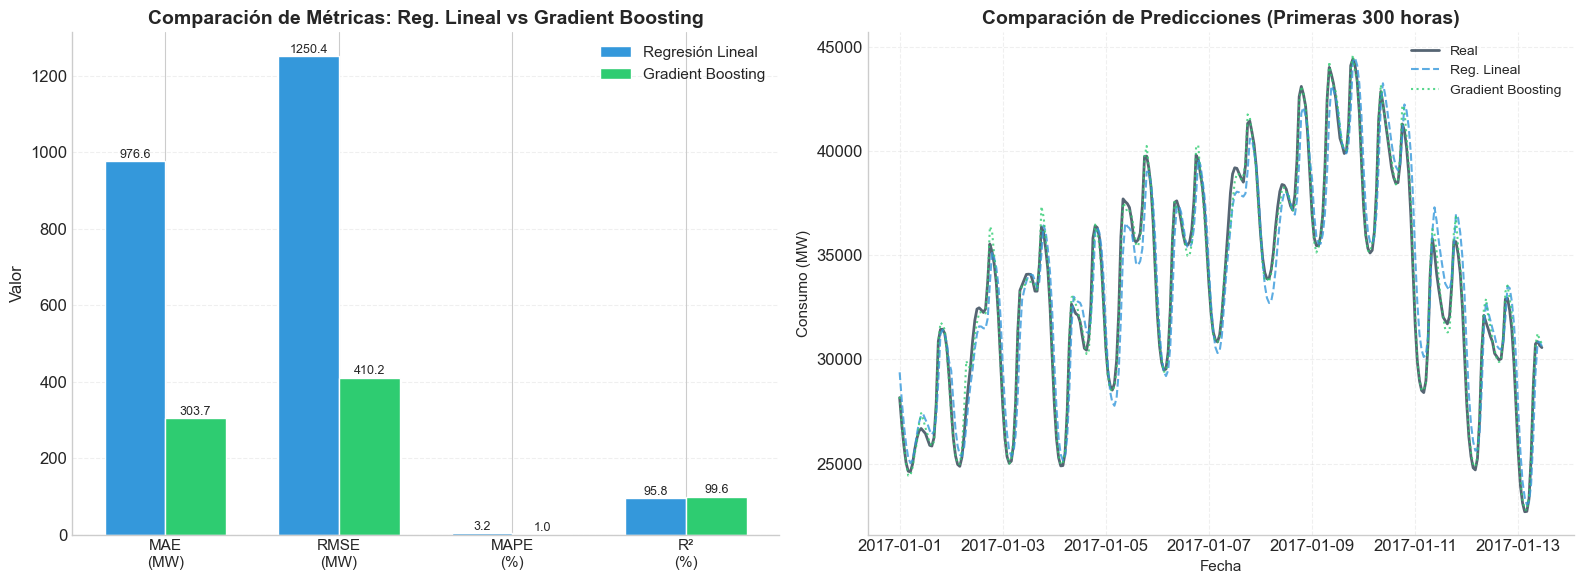

In [37]:
# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Comparación de métricas
ax1 = axes[0]
x = np.arange(4)
width = 0.35

valores_lr = [mae_lr, rmse_lr, mape_lr, r2_lr*100]
valores_gb = [mae_gb, rmse_gb, mape_gb, r2_gb*100]
labels = ['MAE\n(MW)', 'RMSE\n(MW)', 'MAPE\n(%)', 'R²\n(%)']

bars1 = ax1.bar(x - width/2, valores_lr, width, label='Regresión Lineal', color='#3498db', edgecolor='white')
bars2 = ax1.bar(x + width/2, valores_gb, width, label='Gradient Boosting', color='#2ecc71', edgecolor='white')

ax1.set_ylabel('Valor', fontsize=12)
ax1.set_title('Comparación de Métricas: Reg. Lineal vs Gradient Boosting', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, fontsize=11)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y', linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Añadir valores a la barras
for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{bar.get_height():.1f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{bar.get_height():.1f}', ha='center', va='bottom', fontsize=9)

# Gráfico 2: Comparación de predicciones
ax2 = axes[1]
sample = 300

ax2.plot(test.index[:sample], y_test.values[:sample], 
         color='#2c3e50', linewidth=2, label='Real', alpha=0.8)
ax2.plot(test.index[:sample], y_pred_lr[:sample], 
         color='#3498db', linewidth=1.5, linestyle='--', label='Reg. Lineal', alpha=0.8)
ax2.plot(test.index[:sample], y_pred_gb[:sample], 
         color='#2ecc71', linewidth=1.5, linestyle=':', label='Gradient Boosting', alpha=0.8)

ax2.set_title('Comparación de Predicciones (Primeras 300 horas)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Fecha', fontsize=11)
ax2.set_ylabel('Consumo (MW)', fontsize=11)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

---
## 9. Conclusiones y Próximos Pasos

In [38]:
print("Resumen del Modelo Gradient Boosting")

print(f"\nDatos Utilizados:")
print(f"   - Entrenamiento: {len(train):,} registros")
print(f"   - Test: {len(test):,} registros")

print(f"\nConfiguracion del Modelo:")
print(f"   - Algoritmo: Scikit-learn GradientBoostingRegressor")
print(f"   - Tiempo de entrenamiento: {training_time:.2f} segundos")

print(f"\nMétricas Gradient Boosting:")
print(f"   - MAE:   {mae_gb:>10,.2f} MW")
print(f"   - RMSE:  {rmse_gb:>10,.2f} MW")
print(f"   - R²:    {r2_gb:>10.4f}")
print(f"   - MAPE:  {mape_gb:>10.2f} %")

print(f"\nComparación con Regresión Lineal:")
if mae_gb < mae_lr:
    print(f"   - Gradient Boosting reduce el MAE en {((mae_lr-mae_gb)/mae_lr)*100:.1f}%")
    print(f"   - Mejora en R² de {r2_lr:.4f} a {r2_gb:.4f}")
else:
    print(f"   [-] Regresión Lineal tiene mejor rendimiento")

print(f"\nVariables más importantes:")
for i, row in importance_df.nlargest(3, 'Importance').iterrows():
    print(f"   {row['Feature']}: {row['Importance_Pct']:.1f}%")

Resumen del Modelo Gradient Boosting

Datos Utilizados:
   - Entrenamiento: 131,446 registros
   - Test: 13,896 registros

Configuracion del Modelo:
   - Algoritmo: Scikit-learn GradientBoostingRegressor
   - Tiempo de entrenamiento: 143.72 segundos

Métricas Gradient Boosting:
   - MAE:       303.73 MW
   - RMSE:      410.19 MW
   - R²:        0.9955
   - MAPE:        0.96 %

Comparación con Regresión Lineal:
   - Gradient Boosting reduce el MAE en 68.9%
   - Mejora en R² de 0.9583 a 0.9955

Variables más importantes:
   lag_1: 95.2%
   hour: 3.9%
   lag_24: 0.4%
